# Lecture 11: Introduction to Differential Programming with JAX

# Overview:

# 1. JAX Basics
# 2. Lorenz System
# 3. JAX-FEM

In [1]:
import jax
import jax.numpy as np
from jax import random
from jax.flatten_util import ravel_pytree
from jax.scipy.special import logsumexp
from jax_fem.problem import Problem
from jax_fem.solver import solver, ad_wrapper
from jax_fem.generate_mesh import rectangle_mesh
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import get_meshio_cell_type, Mesh, rectangle_mesh
import numpy as onp
from functools import partial
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import time
from functools import partial
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



/Users/tianjuxue/miniconda3/envs/fenics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. JAX Basics

## 1.1 Just-in-time Compilation (JIT): `jit`

In order to speed up your code, you can use the `jit` decorator, which will cached your operation. Let's compare the speed with and without `jit`.

In [2]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * np.where(x > 0, x, alpha * np.exp(x) - alpha)

key = random.PRNGKey(0)
x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

8.83 ms ± 714 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
selu_jit = jax.jit(selu)
%timeit selu_jit(x).block_until_ready()

1.88 ms ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 1.2 Automatic Differentiation: `grad`

Taking the gradient in JAX is pretty easy, you just need to call the `grad` function from the JAX library. Let's begin with a simple example that is calculating the grad of $x^2$. From calculus, we know that:

$$
\frac{\partial x^2}{\partial x} = 2 x
$$

$$
\frac{\partial^2 x^2}{\partial x^2} = 2
$$

$$
\frac{\partial^3 x^2}{\partial x^3} = 0
$$


In [4]:
square = lambda x: np.square(x)

grad_square = jax.grad(square)
grad_grad_square = jax.grad(jax.grad(square))
grad_grad_grad_square = jax.grad(jax.grad(jax.grad(square)))
print(f"grad 2² = ", grad_square(2.))
print(f"grad grad 2² = ", grad_grad_square(2.))
print(f"grad grad grad 2² = ", grad_grad_grad_square(2.))

grad 2² =  4.0
grad grad 2² =  2.0
grad grad grad 2² =  0.0


## 1.3 Vectorizing Map: `vmap`

`vmap`, or vectorizing map, maps a function along array axes, having better performance mainly when is composed with `jit`. Let's apply this for matrix-vector products.

In [5]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return np.dot(mat, v)

In order to batch naively, we can use a for loop to batch.

In [6]:
def naively_batched_apply_matrix(v_batched):
  return np.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
666 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now we can use vmap to batch our multiplication


In [7]:
@jax.jit
def vmap_batched_apply_matrix(v_batched):
  return jax.vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
27.9 µs ± 558 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 1.4 Training a neural network with JAX

This example is directly taken from the JAX official [user guide](https://docs.jax.dev/en/latest/notebooks/neural_network_with_tfds_data.html).

We will first specify and train a simple MLP on MNIST using JAX for the computation. We will use PyTorch’s data loading API to load images and labels (because it’s pretty great, and the world doesn’t need yet another data loading library).

We will see how `jit`, `grad` and `vmap` are used to achieve the goal.

### Neural Network Parameter Initialization

**Mathematical Formulation**:
For a neural network with layer dimensions $[d_0, d_1, ..., d_L]$:
- Weight matrices: $W^{(l)} \in \mathbb{R}^{d_l \times d_{l-1}}$
- Bias vectors: $b^{(l)} \in \mathbb{R}^{d_l}$

**Initialization Strategy**:
$$
\begin{aligned}
W^{(l)} &= \mathcal{N}(0, \sigma^2) \cdot \text{scale} \\
b^{(l)} &= \mathcal{N}(0, \sigma^2) \cdot \text{scale}
\end{aligned}
$$

**Key Components**:
- `random_layer_params`: Initializes parameters for one layer using JAX's PRNG
- `init_network_params`: Creates parameter list for all layers
- Layer sizes `[784, 512, 512, 10]` indicate:
  - Input dimension: 784 (MNIST 28x28 pixels)
  - Hidden layers: 512 units each
  - Output: 10 classes

In [8]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = jax.random.split(key)
    return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 3
batch_size = 128
n_targets = 10
network_params = init_network_params(layer_sizes, jax.random.key(0))

### Neural Network Architecture

**Activation Function** (ReLU):
$$
\text{ReLU}(x) = \max(0, x)
$$

**Forward Propagation**:
For layer $l$ in $1,\ldots,L-1$:
$$
a^{(l)} = W^{(l)}x^{(l-1)} + b^{(l)} \\
x^{(l)} = \text{ReLU}(a^{(l)})
$$

**Final Layer** (Log-Softmax):
$$
\text{output} = \textrm{log\_softmax}(W^{(L)}x^{(L-1)} + b^{(L)})
$$

**Implementation Details**:
- `predict`: Computes per-example predictions
- `batched_predict`: Uses `vmap` for vectorized batch processing


Note that we’re defining this for a single image example. 
We’re going to use JAX’s `vmap` function to automatically handle mini-batches, with no performance penalty.

In [9]:
def relu(x):
    return np.maximum(0, x)

def predict(network_params, image):
    # per-example predictions
    activations = image
    for w, b in network_params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = network_params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

Let’s check that our prediction function only works on single images.

In [10]:
# This works on single examples
random_flattened_image = jax.random.normal(random.key(1), (28 * 28,))
preds = predict(network_params, random_flattened_image)
print(preds.shape)

(10,)


In [11]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.key(1), (10, 28 * 28))
try:
    preds = predict(network_params, random_flattened_images)
except TypeError:
    print('Invalid shapes!')

Invalid shapes!


In [12]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = jax.vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(network_params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


At this point, we have all the ingredients we need to define our neural network and train it. 
We’ve built an auto-batched version of predict, which we should be able to use in a loss function. 
We should be able to use grad to take the derivative of the loss with respect to the neural network parameters. 
Last, we should be able to use jit to speed up everything.

#### Training Infrastructure

**One-Hot Encoding**:
$$
y_{\text{onehot}}^{(i)}[k] = 
\begin{cases}
1 & \text{if } k = y^{(i)} \\
0 & \text{otherwise}
\end{cases}
$$

**Accuracy Calculation**:
$$
\text{Accuracy} = \frac{1}{N}\sum_{i=1}^N \mathbb{I}(\arg\max \hat{y}^{(i)} = \arg\max y^{(i)})
$$

**Cross-Entropy Loss**:
$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K y_k^{(i)} \log p_k^{(i)}
$$


**Key Components**:
- `update`: JIT-compiled parameter update using `jax.grad`
- Automatic differentiation handles complex gradient calculations through the network

In [13]:
def one_hot(x, k, dtype=np.float64):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

def accuracy(network_params, images, targets):
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(batched_predict(network_params, images), axis=1)
    return np.mean(predicted_class == target_class)

# def loss(network_params, images, targets):
#     preds = batched_predict(network_params, images)
#     return -np.mean(preds * targets)

def loss(network_params, images, targets):
    preds = batched_predict(network_params, images)
    class_log_likelihoods = np.sum(preds * targets, axis=1)  # Sum over classes
    return -np.mean(class_log_likelihoods)  # Mean over samples
    
@jax.jit
def update(network_params, x, y):
    grads = jax.grad(loss)(network_params, x, y)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(network_params, grads)]

**Data loader** JAX is laser-focused on program transformations and accelerator-backed NumPy, so we don’t include data loading or munging in the JAX library. There are already a lot of great data loaders out there, so let’s just use them instead of reinventing anything. We’ll grab PyTorch’s data loader, and make a tiny shim to make it work with NumPy arrays.

In [14]:
data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = np.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = np.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


### Training Process

**Data Preparation**:
- MNIST images flattened to $[N, 784]$
- Pixel values not normalized (original range [0, 255])
- Labels converted to one-hot encoding

**Training Dynamics**:
1. **Epoch Loop**: Process entire dataset `num_epochs` times
2. **Batch Processing**:
   $$
   \theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}_{batch}(\theta)
   $$
3. **Validation**:
   - Compute accuracy on full training and test sets
   - Monitor for overfitting via generalization gap

**Performance Metrics**:
- **Training Time**: Tracked per epoch
- **Accuracy Measurements**:
  - Training Accuracy: Model performance on seen data
  - Test Accuracy: Model generalization capability

In [15]:
def get_train_batches():
    # as_supervised=True gives us the (image, label) as a tuple instead of a dict
    ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
    # You can build up an arbitrary tf.data input pipeline
    ds = ds.batch(batch_size).prefetch(1)
    # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
    return tfds.as_numpy(ds)

for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in get_train_batches():
        x = np.reshape(x, (len(x), num_pixels))
        y = one_hot(y, num_labels)
        network_params = update(network_params, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(network_params, train_images, train_labels)
    test_acc = accuracy(network_params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

2025-04-22 16:21:00.351975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 in 4.73 sec
Training set accuracy 0.9730833172798157
Test set accuracy 0.9680999517440796


2025-04-22 16:21:07.518550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 in 4.25 sec
Training set accuracy 0.9836833477020264
Test set accuracy 0.972599983215332


2025-04-22 16:21:12.774368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 in 4.33 sec
Training set accuracy 0.9893333315849304
Test set accuracy 0.9768999814987183


# 2. Lorenz System

We will study the numerical solutions of Lorenz system using **explicit** and **implicit** Euler methods. 
Then, we will show how to compute the derivatives.

## 2.1. Lorenz System Definition
The Lorenz system is defined by three coupled nonlinear ODEs:

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $ \mathbf{y} = [x, y, z]^T $ is the state vector, and $ \sigma, \rho, \beta $ are system parameters.

In [16]:
# Define Lorenz system RHS
def lorenz_rhs(state, params):
    rho, sigma, beta = params
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt])

## 2.2 Explicit Euler Method

The explicit Euler method approximates:

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot \mathbf{f}(\mathbf{y}_n, t_n)
$$

For the Lorenz system:

$$
\begin{aligned}
x_{n+1} &= x_n + \Delta t[\sigma(y_n - x_n)] \\
y_{n+1} &= y_n + \Delta t[x_n(\rho - z_n) - y_n] \\
z_{n+1} &= z_n + \Delta t[x_n y_n - \beta z_n]
\end{aligned}
$$

**Note**: The explicit Euler updating scheme fits into the framework we discussed in Lecture 10:
$$
\begin{aligned}
\boldsymbol{U}^{n} = \boldsymbol{F}(\boldsymbol{U}^{n-1}, \boldsymbol{\Theta})
\end{aligned}
$$
where $\boldsymbol{U}^{n}=\mathbf{y}_n$ and $\boldsymbol{\Theta}=[\sigma, \rho, \beta]$

Final state: [-9.10891 -8.42038 28.64831]


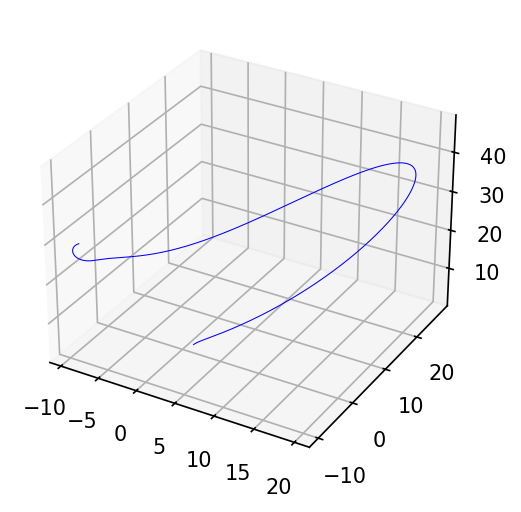

In [17]:
# Explicit euler integration scheme
@jax.jit
def explicit_euler(y_current, params):
    y_next = y_current + dt * lorenz_rhs(y_current, params)
    return y_next

# Integration function
def integrate_lorenz_explicit(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = explicit_euler(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys

# Integration parameters
dt = 0.001
# total_time = 1.0
total_time = 1.
num_steps = int(total_time / dt)

# Lorenz system parameters
params = np.array([28.0, 10.0, 8.0/3.0])  # rho, sigma, beta
# Initial conditions
y0 = np.array([1.0, 1.0, 1.0])

yf, ys = integrate_lorenz_explicit(y0, params)
print("Final state:", yf)

# Visualize the results
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

## 2.3 Implicit Euler Method


The implicit Euler method solves:

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot \mathbf{f}(\mathbf{y}_{n+1}, t_{n+1})
$$

This results in a nonlinear system to solve at each step:

$$
\mathbf{F}(\mathbf{y}_{n+1}) = \mathbf{y}_{n+1} - \mathbf{y}_n - \Delta t \cdot \mathbf{f}(\mathbf{y}_{n+1}) = 0
$$

**Newton-Raphson Iteration**

Solve $ \mathbf{F}(\mathbf{y}_{n+1}) = 0 $ using:

$$
\mathbf{y}_{n+1}^{(k+1)} = \mathbf{y}_{n+1}^{(k)} - [J_F(\mathbf{y}_{n+1}^{(k)})]^{-1} \mathbf{F}(\mathbf{y}_{n+1}^{(k)})
$$

Where the Jacobian $ J_F $ is:

$$
J_F = I - \Delta t \cdot J(\mathbf{y}_{n+1}^{(k)})
$$

The term $ J(\mathbf{y}) = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} $ for Lorenz system:

$$
J(\mathbf{y}) = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

Remark: We can use AD to compute this Jacobian.

**Note**: The implicit Euler updaing scheme fits into the framework we discussed in Lecture 10:
$$
\begin{aligned}
\boldsymbol{U}^{n} &= \boldsymbol{U}^n(\boldsymbol{U}^{n-1}, \boldsymbol{\Theta})
\end{aligned}
$$
where the implicit relation is defined through the following residual function:
$$
\begin{aligned}
\boldsymbol{R}(\boldsymbol{U}^{n}, \boldsymbol{U}^{n-1}, \boldsymbol{\Theta})&=\boldsymbol{0}
\end{aligned}
$$

Final state: [-9.65703 -8.3499  30.01758]


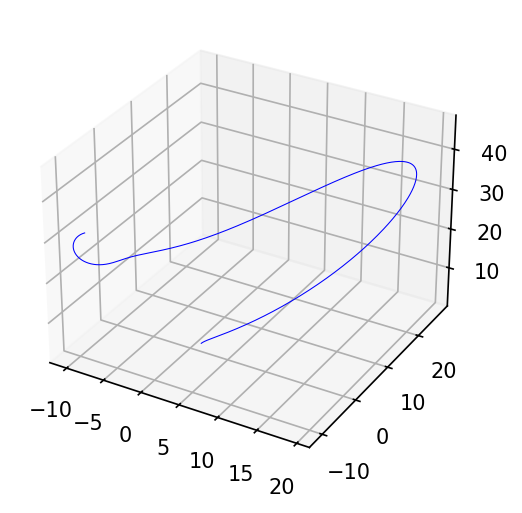

In [18]:
# Residual function R
def residual(y_next, y_current, param):
    return y_next - y_current - dt * lorenz_rhs(y_next, params)

@jax.jit
def implicit_euler(y_current, params):

    # Initial guess using explicit Euler
    y_guess = y_current + dt * lorenz_rhs(y_current, params)
    
    # Initialize loop state: (iteration, y_guess, residual_norm, converged)
    init_state = (np.array(0, dtype=np.int32), y_guess, np.array(np.inf, dtype=np.float64))

    def cond_fn(state):
        iteration, _, residual_norm = state
        max_iters=100
        tol=1e-8
        return (iteration < max_iters) & (residual_norm > tol)

    def body_fn(state):  
        iteration, y, _ = state
        F = residual(y, y_current, params)
        J = jax.jacfwd(residual)(y, y_current, params)
        delta = np.linalg.solve(J, -F)
        y_new = y + delta
        residual_norm = np.linalg.norm(F)
        return iteration + 1, y_new, residual_norm

    # Run Newton iterations
    final_state = jax.lax.while_loop(cond_fn, body_fn, init_state)
    y_next = final_state[1]
    
    return y_next

# Integration function
def integrate_lorenz_implicit(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = implicit_euler(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys
    
# Integration parameters
dt = 0.001
# total_time = 1.0
total_time = 1.
num_steps = int(total_time / dt)

# Perform integration
yf, ys = integrate_lorenz_implicit(y0, params)
print("Final state:", yf)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

## 2.4 Derivatives for Explicit Euler Method

Let $L(\boldsymbol{U}^{0}, \boldsymbol{\Theta})$ be the objective function depending on both initial value $\boldsymbol{U}^{0}$ and parameters $\boldsymbol{\Theta}$. 

The goal is to find the total derivative $\frac{dL}{d\boldsymbol{U}^{0}}$ and $\frac{dL}{d\boldsymbol{\Theta}}$.

In JAX, you can directly call `jax.grad` since everything is explicit.

You may need to use `jax.checkpoint` if memory is an issue.

In [19]:
def loss_explicit(y0, params):
    yf, _ = integrate_lorenz_explicit(y0, params)
    return np.sum(yf**2) + np.sum(params**2)

grad_ad = jax.grad(loss_explicit, argnums=(0, 1))(y0, params)
print(f"AD derivative = {grad_ad}")

AD derivative = (Array([-11.7421 , -10.74929,  38.72791], dtype=float64), Array([ 70.40913,  22.95309, 340.3513 ], dtype=float64))


In [20]:
h = 1e-3
val_minus = loss_explicit(y0.at[0].add(-h), params)
val_plus = loss_explicit(y0.at[0].add(h), params)
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = -11.742094756982624


In [21]:
val_minus = loss_explicit(y0, params.at[2].add(-h))
val_plus = loss_explicit(y0, params.at[2].add(h))
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 340.35141685512826


## 2.5 Derivatives for Implicit Euler Method

Let $L(\boldsymbol{U}^{0}, \boldsymbol{\Theta})$ be the objective function depending on both initial value $\boldsymbol{U}^{0}$ and parameters $\boldsymbol{\Theta}$. 

The goal is to find the total derivative $\frac{dL}{d\boldsymbol{U}^{0}}$ and $\frac{dL}{d\boldsymbol{\Theta}}$.

In this implicit senario, directly calling `jax.grad` is a bad practice since it will differentiate through the internal loops of Newton's method. 

In [22]:
def loss_implicit(y0, params):
    yf, _ = integrate_lorenz_implicit(y0, params)
    return np.sum(yf**2) + np.sum(params**2)

# Differentiation through the internal loops (bad practice)
# This should be avoided due to efficiency, even if you use fori_loop and make the code run with a correct returning value.
# grad_ad = jax.grad(loss_implicit, argnums=(0, 1))(y0, params)

The good practice is to use the adjoint method and define customized VJP for the update function, as we discussed in Lecture 10. 

In [23]:
# Define custom VJP for the function fwd
def ad_wrapper_lorenz(fwd):
    @jax.custom_vjp
    def fwd_wrapped(y_current, params):
        y_next = fwd(y_current, params)
        return y_next

    def f_fwd(y_current, params):
        y_next = fwd_wrapped(y_current, params)
        return y_next, (y_next, y_current, params)

    @jax.jit
    def f_bwd(res, v):
        # print("Running backward and solving the adjoint problem...")
        y_next, y_current, params = res
        J = jax.jacfwd(residual)(y_next, y_current, params)
        adjoint = np.linalg.solve(J.T, -v)
        primals_out, f_vjp = jax.vjp(lambda y_current, params: residual(y_next, y_current, params), y_current, params)
        vjp_y_current, vjp_params = f_vjp(adjoint)
        return vjp_y_current, vjp_params

    fwd_wrapped.defvjp(f_fwd, f_bwd)
    return fwd_wrapped

# implicit_euler_wrapped will follow the user-defined behavior for reverse-mode AD
implicit_euler_wrapped = ad_wrapper_lorenz(implicit_euler)

# Redefine the integration function using implicit_euler_wrapped
def integrate_lorenz_implicit_wrapped(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = implicit_euler_wrapped(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys

# Redefine the loss function using integrate_lorenz_implicit_wrapped
def loss_implicit_wrapped(y0, params):
    yf, _ = integrate_lorenz_implicit_wrapped(y0, params)
    return np.sum(yf**2) + np.sum(params**2)
    
grad_ad = jax.grad(loss_implicit_wrapped, argnums=(0, 1))(y0, params)
print(f"AD derivative = {grad_ad}")

AD derivative = (Array([-28.13924, -23.98771,  40.72138], dtype=float64), Array([56.     , 20.     ,  5.33333], dtype=float64))


In [24]:
h = 1e-3
val_minus = loss_implicit_wrapped(y0.at[2].add(-h), params)
val_plus = loss_implicit_wrapped(y0.at[2].add(h), params)
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 40.72137833838951


In [25]:
val_minus = loss_implicit_wrapped(y0, params.at[2].add(-h))
val_plus = loss_implicit_wrapped(y0, params.at[2].add(h))
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 5.333333333283008


# 3. JAX-FEM

## 3.1. Strong Form and Weak Form

**Strong Form**

The Poisson equation is a classical elliptic partial differential equation (PDE) commonly used to describe equilibrium or steady-state diffusion processes, such as steady-state heat conduction and electrostatic fields. In this case study, we consider a Poisson equation boundary value problem defined on a two-dimensional computational domain Ω = (0,1) × (0,1):

$$
\begin{align*}
    -\nabla \cdot (\theta(\boldsymbol{x})\nabla u) = g & \quad \text{in } \Omega, \\
    u = 0 & \quad \text{on } \Gamma_D, \\
    k(\boldsymbol{x})\nabla u \cdot \boldsymbol{n} =0 &\quad \text{on } \Gamma_N
\end{align*}
$$
where $\theta(\boldsymbol{x})$ is the nonhomogeneous heat conductivity.

Zero-value Dirichlet boundary conditions are applied on the left and right boundaries of the domain Ω, i.e., 
$$
\Gamma_D = \{(0, y) \cup (1, y) \subset \partial\Omega\}
$$

We consider a volumetric source term defined as:
$$
g = 10\exp\left(-\frac{(x-0.5)^2 + (y-0.5)^2}{0.02}\right)
$$

**Weak Form**

We first derive the weak form of the aforementioned Poisson equation: First, multiply both sides of the governing equation by the test function $v$:
$$
-\int_\Omega (\nabla \cdot (\theta(\boldsymbol{x})\nabla u)) v \, dx = \int_\Omega g \, v \, dx
$$
From integration by parts:
$$
\int_\Omega \theta(\boldsymbol{x}) \nabla u \cdot \nabla v \, dx - \int_{\partial \Omega} \theta(\boldsymbol{x})\frac{\partial u}{\partial n} v \, ds = \int_\Omega g \, v \, dx
$$
Consider boundary conditions, we obtain the final weak form expression:
$$
\int_\Omega k(\boldsymbol{x})\nabla u \cdot \nabla v \, dx = \int_\Omega g \, v \, dx
$$


## 3.2 Implementation in JAX-FEM

**Galarkin weak form**

We first define the aforementioned weak form based on the `Problem` base class to derive our problem subclass. When defining weak forms in `jax-fem`, a crucial concept is `kernel`, which helps us define weak forms corresponding to partial differential equations in a more universal and efficient way. This concept also appears in many other open-source finite element software (e.g., `MOOSE`).

`jax-fem` currently includes two types of `kernel`, used for computing volume integrals and boundary integrals respectively. The volume integrals constituting the aforementioned weak form can be divided into three categories:

* **Laplace Kernel**  
$$\int_{\Omega} f(\nabla u, \theta)\cdot \nabla v$$

* **Mass Kernel**  
$$\int_{\Omega}g(u,\theta)v$$

* **Universal Kernel** (More general weak form definition, commonly used for multi-physics coupling problems, to be explained in subsequent tutorials)

To define the aforementioned weak form, we do not need to define the complete computation process, only need to define the functions $f(\nabla u,\theta)$ and $g(u,\theta)$, where $\theta$ represents input parameters. 
These correspond to `tensor_map` and `mass_map` in the code below. 
Note these two functions must be returned (as functions) by `get_tensor_map` and `get_mass_map` respectively.

In [26]:
class Poisson(Problem):
    def get_tensor_map(self):
        """Defines Laplace operator"""
        def tensor_map(u_grad, theta):
            # Deals with ∇u·∇v
            return theta*u_grad  
        return tensor_map
    
    def get_mass_map(self):
        """Defines source term"""
        def mass_map(u, x, theta):
            # Deals with g*v
            return -np.array([10*np.exp(-(np.power(x[0] - 0.5, 2) + np.power(x[1] - 0.5, 2)) / 0.02)])
        return mass_map

    def set_params(self, thetas):
        self.internal_vars = [thetas]

**Generate Mesh**

Next, we proceed to the definition of the mesh model. For the quadrilateral elements in this case, we can directly use the `rectangle_mesh` function from the `jax_fem.generate_mesh` module to perform structured mesh generation. For other complex mesh models, we can first create models using professional pre-processing or commercial software, generate meshes, export them as mesh data files, and then import them using `meshio`.

In [27]:
# Define the mesh
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Lx, Ly = 1., 1.
meshio_mesh = rectangle_mesh(Nx=64, Ny=64, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

**Specify Boundary Conditions**

Next, we proceed to the definition of boundary conditions. For Dirichlet boundary conditions defined on $\partial\Omega$, we need to define them from three aspects:
* **"Where"**: Define functions identifying boundary regions
* **"What value"**: Define boundary values imposed on these boundaries
* **"Which component"**: Specify which component of the solution to constrain

The code below demonstrates the standard workflow in `jax-fem` for defining Dirichlet boundary conditions, corresponding one-to-one with the three aspects mentioned above. Regarding the third aspect, since the solution to the Poisson problem is a scalar quantity, the constrained component indices are all `0`.

In [28]:
# Define the boudanry conditions
def left(point):
    return np.isclose(point[0], 0., atol=1e-5)

def right(point):
    return np.isclose(point[0], Lx, atol=1e-5)

def dirichlet_val_zero(point):
    return 0.

# location of each boundary part
location_fns = [left, right]
# What's the assigned value on each boundary part
# for this example, all the value functions are the same
value_fns = [dirichlet_val_zero] * 2
# which component of the solution on each boundary is constrained? （0 -- x, 1 -- y, 2 -- z）
vecs = [0, 0]

# construct the Dirichlet boundary conditions struct
dirichlet_bc_info = [location_fns, vecs, value_fns]

**Define the problem, solve it, and save the solution**

In [29]:
# Define the problem
problem = Poisson(mesh=mesh, 
                  vec=1, 
                  dim=2, 
                  ele_type=ele_type, 
                  dirichlet_bc_info=dirichlet_bc_info)

# (num_cells, num_quads, dim)
quad_points = problem.fes[0].get_physical_quad_points()

# The parameter array thetas is defined at all quadrature points
thetas = np.ones(quad_points.shape[:2])

# Set the parameters
problem.set_params(thetas)

# Solve the problem
sol_list = solver(problem)

# Save the solution
save_sol(problem.fes[0], sol_list[0], './output/sol.vtk')

[04-22 16:21:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[04-22 16:21:20][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[04-22 16:21:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[04-22 16:21:21][DEBUG] jax_fem: Done pre-computations, took 1.0783791542053223 [s]
[04-22 16:21:21][INFO] jax_fem: Solving a problem with 4096 cells, 4225x1 = 4225 dofs.
[04-22 16:21:22][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[04-22 16:21:22][DEBUG] jax_fem: Start timing
[04-22 16:21:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[04-22 16:21:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.3062 seconds
[04-22 16:21:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[04-22 16:21:25][DEBUG] jax_fem: Before, l_2 res = 0.027638418037936253, relative l_2 res = 1.0
[04-22 16:21:25][DEBUG] jax_fem: Solving linear system...
[04-22 16:21:25][D

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## 3.3 Implicit differentiation using JAX-FEM

**Find the gradient**

We will use the adjoint implicit differentiation method by JAX-FEM to find the gradient and compare that with a finite difference approach.

In [30]:
fwd_pred = ad_wrapper(problem) 

def J(thetas):
    sol_list = fwd_pred(thetas)
    return np.sum(sol_list[0]**2)

grad_ad = jax.grad(J)(thetas)

h = 1e-3
value_minus = J(thetas.at[0, 0].add(-h))
value_plus = J(thetas.at[0, 0].add(h))
grad_fd = (value_plus - value_minus)/(2.*h)

print(f"grad_ad.shape = {grad_ad.shape}")
print(f"grad_fd.shape = {grad_fd.shape}")
print(f"grad_ad can give the gradient all at once, but grad_fd can only give one value!")
print(f"Let's compare the value by both methods:")
print(f"grad_ad[0, 0] = {grad_ad[0, 0]}")
print(f"grad_fd = {grad_fd}")

[04-22 16:21:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[04-22 16:21:26][DEBUG] jax_fem: Start timing
[04-22 16:21:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[04-22 16:21:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0081 seconds
[04-22 16:21:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[04-22 16:21:26][DEBUG] jax_fem: Before, l_2 res = 0.027638418037936253, relative l_2 res = 1.0
[04-22 16:21:26][DEBUG] jax_fem: Solving linear system...
[04-22 16:21:26][DEBUG] jax_fem: JAX Solver - Solving linear system
[04-22 16:21:27][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 8.510159409634758e-11
[04-22 16:21:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[04-22 16:21:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0105 seconds
[04-22 16:21:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[04-22 16:21:27][DEBUG] jax_fem: l_2 res = 8.510158351743886e-11, relative l_2 

grad_ad.shape = (4096, 4)
grad_fd.shape = ()
grad_ad can give the gradient all at once, but grad_fd can only give one value!
Let's compare the value by both methods:
grad_ad[0, 0] = -0.004794612095758944
grad_fd = -0.004794615236392019
